**Problem 2**

In [ ]:
# import the CSV file from GitHub:
CSV_URL = 'https://raw.githubusercontent.com/oriyonay/RandomPublicThings/master/hw5_question2.csv'
df = pd.read_csv(CSV_URL, header=None)

In [ ]:
# does the data contain any missing values?
print('Missing values: %d' % df.isnull().sum().sum())

Missing values: 0


No missing values in the data. Great!

In [ ]:
# separate the features and labels:
features = df.loc[:, df.columns != 9]
outcome = df[9]

Since the data is entirely discrete, there is no need to further preprocess it.

In [ ]:
# 2a) Compute the number (and percentage) of samples belonging to the benign and malignant classes:
print('Number of benign (2) and malignant (4) samples:')
print(outcome.value_counts(normalize=False))

print('\nPercentage of benign (2) and malignant (4) samples:')
print(outcome.value_counts(normalize=True) * 100)

Number of benign (2) and malignant (4) samples:
2    444
4    239
Name: 9, dtype: int64

Percentage of benign (2) and malignant (4) samples:
2    65.007321
4    34.992679
Name: 9, dtype: float64


From the data above, we can observe that the malignant class is underrepresented in the dataset. 

In [ ]:
# Split the data into train and test sets, ensuring both variables are proportionally represented
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.33, stratify=outcome)

It is important to note that since the training data is *disproportionately represented*, it is best to use a method such as AUROC to plot accuracy rather than a simple accuracy function.

In [ ]:
# 2b) Create and train two decision trees using the training samples:

# defining a function that cross-validates two decision tree classifiers 
# (using entropy and gini index as splitting criterion):
def cross_validate_models(max_depth, num_of_folds=10):
  auc_dict = {'dtc_entropy': 0,  'dtc_gini': 0}

  skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True)
  for train_index, test_index in skf.split(features, outcome):
    # Splitting the data:
    train_inputs = features.iloc[train_index]
    train_outputs = outcome[train_index]
    test_inputs = features.iloc[test_index]
    test_outputs = outcome[test_index]

    # Train the models on the data:
    dtc_entropy = DecisionTreeClassifier(criterion = 'entropy', max_depth=max_depth)
    dtc_gini = DecisionTreeClassifier(criterion = 'gini', max_depth=max_depth)
    dtc_entropy.fit(X_train, y_train)
    dtc_gini.fit(X_train, y_train)

    # use these models to predict values:
    dtc_entropy_pred = dtc_entropy.predict(test_inputs)
    dtc_gini_pred = dtc_gini.predict(test_inputs)

    # calculate ROC scores for these models:
    dtc_entropy_roc = roc_auc_score(test_outputs, dtc_entropy_pred)
    dtc_gini_roc = roc_auc_score(test_outputs, dtc_gini_pred)

    # add the contribution to the average AUROC score:
    auc_dict['dtc_entropy'] += dtc_entropy_roc / num_of_folds
    auc_dict['dtc_gini'] += dtc_gini_roc / num_of_folds

  # return the auc scores:
  return auc_dict

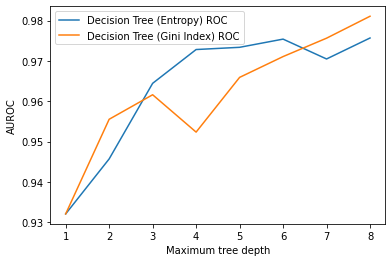

In [ ]:
# plotting the 10-fold cross-validated accuracy on the training and testing data:
num_features = len(features.columns)
max_depths = list(range(1, num_features))

# keep track of the ROC scores for both models:
dtc_entropy_rocs = []
dtc_gini_rocs = []

for depth in max_depths:
  # train the model with the given max depth:
  auc_dict_ = cross_validate_models(max_depth=depth)

  # store the ROC scores:
  dtc_entropy_rocs.append(auc_dict_['dtc_entropy'])
  dtc_gini_rocs.append(auc_dict_['dtc_gini'])

# plot the accuracies as a function of max depth:
plt.plot(max_depths, dtc_entropy_rocs, label='Decision Tree (Entropy) ROC')
plt.plot(max_depths, dtc_gini_rocs, label='Decision Tree (Gini Index) ROC')
plt.xlabel('Maximum tree depth')
plt.ylabel('AUROC')
plt.legend()
plt.show()

By running this multiple times, I can discern no concrete difference between the two decision trees. The peak accuracy seems to be at a maximum tree depth of around 5-6, where neither trees seem to be underfitting nor overfitting to the data.

In [ ]:
# 2c) Feature importances using Random Forests:
num_of_folds = 10

# to keep track of the AUROC of the random forest:
rf_auc = 0

# to keep track of the feature importances:
feature_importances = []

skf = StratifiedKFold(n_splits=num_of_folds, shuffle=True)
for train_index, test_index in skf.split(features, outcome):
  # Splitting the data:
  train_inputs = features.iloc[train_index]
  train_outputs = outcome[train_index]
  test_inputs = features.iloc[test_index]
  test_outputs = outcome[test_index]

  # Train the random forest on the data:
  rf = RandomForestClassifier()
  rf.fit(X_train, y_train)

  # use the model to predict values:
  rf_pred = rf.predict(test_inputs)

  # store feature importances:
  feature_importances.append(rf.feature_importances_)

  # calculate ROC score for this model:
  rf_roc = roc_auc_score(test_outputs, rf_pred)

  # add the contribution to the average AUROC score:
  rf_auc += rf_roc / num_of_folds

In [ ]:
# print the AUROC score of the random forest classifier:
print('AUROC Score for Random Forest Classifier: %f' % rf_auc)

AUROC Score for Random Forest Classifier: 0.984116


From this AUROC score, we can see that the random forest classifier tends to perform a bit better than the singular decision trees.

In [ ]:
# sort importances from each fold, from most to least important:
indices = [arr[::-1] for arr in np.argsort(feature_importances)]

# calculate the avreage index location for each (average position in the rank order):
avg_indices = [0] * num_features # init array
for rank_arr in indices:
  for i in range(num_features):
    avg_indices[rank_arr[i]] += (i / len(indices))

# use these average indices to calculate the average rank order by their average position in the rank order:
avg_rank_order = np.argsort(avg_indices)

In [ ]:
print('Average rank order: ', avg_rank_order)

Average rank order:  [1 2 5 6 7 4 0 3 8]


In [ ]:
# for visualization purposes, prepare to plot the average feature importances (using the gini index):
avg_feature_importances = []
for rank in avg_rank_order:
  avg_feature_importance = np.mean([arr[rank] for arr in feature_importances])
  avg_feature_importances.append(avg_feature_importance)

avg_feature_importances

[0.26120922772512184,
 0.18176400022980727,
 0.18217179073281803,
 0.13000634709733688,
 0.09105061766912363,
 0.060906786455521,
 0.049545678041531725,
 0.03551511188958182,
 0.00783044015915787]

As an interesting sidenote: this approach does not guarantee that the average feature importances will necessarily be sorted in decreasing order, since it cares about the *average relative rank of the feature importances* rather than the *ranks of the average feature importances*.

That being said, this is not crucial, as the importances will likely remain mostly in order anyway, and will give us a more robust estimation of feature importances.

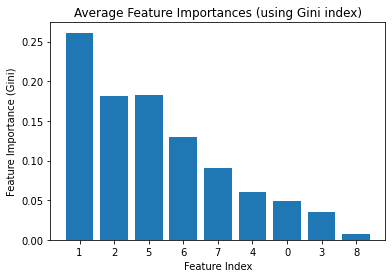

In [ ]:
# plot the average feature importances (using the gini index):
plt.bar(range(num_features), avg_feature_importances)
plt.xticks(range(num_features), avg_rank_order)
plt.title('Average Feature Importances (using Gini index)')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance (Gini)')
plt.show()

In order to determine what should be included in the final list of features, let us first display the cumulative sum of the feature importances, in increasing order (similar to what we would do in determining when to cut off features for PCA).

In [ ]:
print('Cumulative sum of feature importances: ')
print(np.cumsum(avg_feature_importances))

Cumulative sum of feature importances: 
[0.26120923 0.44297323 0.62514502 0.75515137 0.84620198 0.90710877
 0.95665445 0.99216956 1.        ]


From this list, it is clear that in order to get a sufficiently high accuracy rate, almost all features need to be considered. I would suggest that the last feature (index 8, corresponding to *normal nucleoli*) is not necessary in the final model. It does not seem to provide much of an added benefit to the model and may very well lead to overfitting/modeling of random noise. The model contains a small enough set of features that it would still be okay to keep this feature, though it is probably not too important.